# Генерация изображений


Как мы увидели в прошлой теме, генерация образов, даже очень простых, это тяжкий труд. Первая проблема техническая, нужны мощные копьютеры с несколькими графическими ускорителями, чтобы нормально обучать GANы. Поэтому обучением занимаются только компании, которые могут позволить себе такие компьютеры. Остальные же пользуются уже обученными сетями, приспосабливая их для своих целей.

Если мы хотим генерировать качественные изображения, то только мощных компьютеров будет недостаточно. Надо сделать модификации в сети генератора и дискриминатора. Пожалуй одной из самых популярных модификаций для генерации изображений стала сеть [StyleGAN2](https://github.com/NVlabs/stylegan2) для генерации лиц людей от компании NVIDIA. Но по такому же принципу сегодня можно генерировать и другие изображения.

Мы не будем вдаваться в детали устройства этой сети, а лишь отметим идеи, которые в ней заложены.



![img](https://drive.google.com/uc?id=14P-NdGb1iobr6M5E1iNr8GeR3GdJmXkK)

- [**Прогрессивное обучение**](https://machinelearningmastery.com/introduction-to-style-generative-adversarial-network-stylegan/): Генератор и дискриминатор начинают обучение с изображений маленького размера 8 * 8. Когда хорошее обучение на этом размере достигнуто - размер изображения увеличивается и обе сети продолжают обучение. Так постепенно увеличивается размер генерируемых изображений, вплоть до 1024 * 1024. Масштаб изображений постоянно меняется.
* Латентные входы в генератор используются не сами по себе, а преобразуются сначала полносвязной сетью (Mapping network), а затем каждый элемент этого вектора используется для своего сверточного слоя генератора. Т.е. эти латентные входы влияют непосредственно на выход каждого из слоев. Как мы знаем выходы разных слоев описывают разные признаки изображения, что, по-сути, является описанием *стиля* изображения. Стиль изображения это взаимосвязь между пикселями изображения. Можно представить, что теперь латентные переменные это не вход в генератор, а ручки управления им. А в качестве входа, с которого и начинается генерация изображения, используется некоторый массив констант (const). На основе латентных переменных выполняется масштабирование и смещение выходов светочных слоев (элемент AdaIN) (на самом деле, таких стилевых векторов несколько, одна часть генератора использует один, другая - другой).
* Дополнительно к выходам сверточных слоев добавляется Гаусов шум, чтобы получать разнообразные выходы при одном и том же входе.          


## Слои AdaIN

Для лучшего управления стилем используют слои AdaIN (Adaptive Instance Normalization), которые сначала нормализуют каждый канал карты признаков каждого примера независимо, а потом изменяют распределения на заданные, изучаемые в процессе обучения.  

![img](https://blog.kakaocdn.net/dn/FkZZY/btre43b4WLk/I5MKLdFpuk3QCVwLuMc0kk/img.png)

![img](https://theaisummer.com/static/ac89fbcf1c115f07ae68af695c28c4a0/4cfbe/normalization.png)

# Аугментация

Одна из самых сложных проблем для генерации качественных изображений это недостаток данных. Если данных немного, скажем всего 1000 изображений, то дискриминатору будет трудно обучиться хорошо. Чтобы с этим бороться используют **аугментацию** - искуственные преобразования изображений, например повороты, смещения, изменения насыщенности, добавление шума.

В модификации [StyleGAN2-ADA](https://github.com/NVlabs/stylegan2-ada), большое число таких аугментаций применяют налету к "настоящим" и сгенерированным изображениям.  Это позволяет лучше обучать дискриминатор и генератор (не все аугментации полезны, применяются только те, которые дают хороший результат, некоторые примеры на рисунке).

![img](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/stylegan2-ada-teaser-1024x252.jpg "StyleGAN2 Generated Faces")



### Генерация изображений предобученной сетью

Если б мы сами обучали такую сеть генерации изображений, нам потребовалось бы **несколько лет** рассчетов на одном графическом процессоре. Но, к счастью, разработчики дают доступ к уже обученным GAN-сетям. Давайте этим воспользуемся.   
  

Скачиваем и устанавливаем проект StyleGAN3 из GitHub.

In [1]:
!git clone https://github.com/NVlabs/stylegan3
!pip install einops ninja
import sys
sys.path.append('./stylegan3')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
#import clip
#import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files

device = torch.device('cuda:0') # на GPU
print('Using device:', device, file=sys.stderr)

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 5.32 MiB/s, done.
Resolving deltas: 100% (98/98), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 611.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.1 MB/s eta 0:00:00


Using device: cuda:0


In [2]:
#@title  Функции для загрузки
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path:
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename


## Генерация изображений
Подготовим функции для работы.

Латентные переменные определяют, какое изображение будет сгенерировано. В некоторм смысле это неявный номер генерируемого изображения. Давайте будем генерировать латентные переменные нужного размера, а регулировать какие именно будем "сидом" - смещением относительно начала таблицы псевдослучайных чисел.  

In [3]:
# базовый адрес моделей
base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"
# на чем обучалась
Model = 'FFHQ'

# Другие варианты
model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
    "MetFaces": base_url + "stylegan3-r-metfacesu-1024x1024.pkl",
    "AFHQv2": base_url + "stylegan3-t-afhqv2-512x512.pkl",
    "cosplay": "https://l4rz.net/cosplayface-snapshot-stylegan3t-008000.pkl",
    "Wikiart": "https://archive.org/download/wikiart-1024-stylegan3-t-17.2Mimg/wikiart-1024-stylegan3-t-17.2Mimg.pkl",
    "Landscapes": "https://archive.org/download/lhq-256-stylegan3-t-25Mimg/lhq-256-stylegan3-t-25Mimg.pkl"
}

# Выбираем
network_url = model_name[Model]

# Пытаемся загрузить
with open(fetch_model(network_url), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device) # только генератор, усредненный


--2024-03-18 15:08:30--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 44.228.14.81, 100.20.149.112, 44.239.232.238, ...
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|44.228.14.81|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://files.ngc.nvidia.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl?Expires=1710778111&Signature=vxqdbxMUT4LB2TCiS8IKII0z3KU7W1JevYlRDk3eC9LJyItGSJvXVZcOnx1bjJt1FOJpR2nTf-0JSWm1JklVTT6Cqt~-y1f7FZUf3cuqcKzUppnG8JflnmujfKybaLWEkszOf-hYH-0S3Zs1lhITC51LSt0kIVKa9KBMETW3N250GPTnEIGN-qCP3PIQZXfe1Dn3RWSN5nnts-xIOuwAnnf2YqIzhETM3I4ta0I3cNe1bzFS0xZXWCYQsR-F2clO1AgblEwXtLhqzvHQPRCovqcSX8zj3ujqU10wR3FLIzz6OESQ4Kn-grSDNgvNgiqrh7azCXOjk69pwFafJohoEA__&Key-Pair-Id=KCX06E8E9L60W [following]
--2024-03-18 15:08:31--  https://files.ngc.nvidia.com/org/nvidia/team/research/mod

# Уплотнение
Те примеры латентных преобразованных векторов W, что сильно отличаются от прочих довольно редки, генератор дает для них плохие результаты. Часто такие вектора уплотняют, чтобы принимаемые значения были более сконцентрированы вокруг среднего.

ⱳ_new=ⱳ_avg+𝞧(ⱳ -ⱳ_avg)

Кстати, вектора W будучи получены из латентных переменных Z дальше могу использоваться сами по себе, хранить Z и применять постоянно отображающую сеть не требуется.

In [4]:

zs = torch.randn([10000, G.mapping.z_dim], device=device) # какие-то латентные вектора
w_stds = G.mapping(zs, None).std(0) # отображаем их в стилевые W, считаем среднее (уже есть) и разброс.
# Первый запуск может быть долгим!
G.mapping.w_avg; # здесь среднее

Setting up PyTorch plugin "bias_act_plugin"... Done.


truncation_psi - коэффициент уплотнения 𝞧

В поле .mapping.z_dim хранится размерность латентных векторов

Создаем несколько стилевых векторов, уплотняем.

Метод .synthesis() запускает генерацию.

In [28]:
q = (G.mapping(torch.randn([1,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
image=G.synthesis(q * w_stds + G.mapping.w_avg)
# Первый запуск может быть долгим!

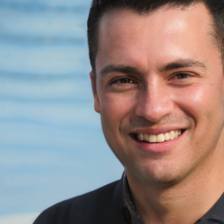

In [29]:
# масштабируем и обрезаем к диапазону (0,1) для рисования. Исходный диапазон примерно (-1,1)
tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])
display(TF.to_pil_image(tf(image)[0])) # отображаем

## (Домашнее задание) Изменение латентных переменных
Похожие латентные переменные дают "похожие" изображения.

Давайте будем постепенно изменять латентные переменные одного изображения на латентные переменные другого и посмотрим какие изображения будут генерироваться.

Изображения как бы "перетекают" одно в другое. Такую опреацию называют **морфинг**.


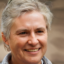

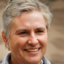

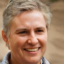

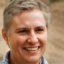

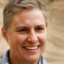

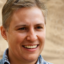

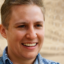

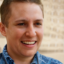

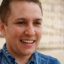

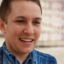

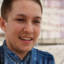

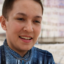

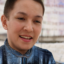

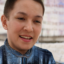

In [7]:
# масштаб картинок
tf = Compose([
  Resize(64),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

# начальная картинка и ее латентный вектор
z1=torch.randn([1,G.mapping.z_dim], device=device)
q1 = (G.mapping(z1, None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
im1=G.synthesis(q1 * w_stds + G.mapping.w_avg)

# конечная картинка и ее латентный вектор
z2=torch.randn([1,G.mapping.z_dim], device=device)
q2 = (G.mapping(z2, None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
im2=G.synthesis(q2 * w_stds + G.mapping.w_avg)


Ngen=12 # число промежуточных шагов
dz=(z2-z1)/Ngen # шаг

z=z1 # начало
display(TF.to_pil_image(tf(im1)[0])) # рисуем начало
for i in range(Ngen): # по всем шагам
  z=z+dz # изменяем вектор
  q=(G.mapping(z, None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
  im=G.synthesis(q * w_stds + G.mapping.w_avg) # содаем картинку для него
  display(TF.to_pil_image(tf(im)[0])) # рисуем ее

display(TF.to_pil_image(tf(im2)[0])) # конечная картинка


# Задания


Попробуйте сами другие предобученные сети:

* https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan2/files
* https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan3/files

Проверьте, как будут изменяться изображения, если менять только один\два элемента латентных переменных.

# Ссылки

Использованы и адаптировны материалы:

* https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_style_gan.ipynb
* https://github.com/NVlabs/stylegan2-ada
* https://github.com/NVlabs/stylegan3
* https://habr.com/ru/company/skillfactory/blog/668090/
* https://medium.com/@steinsfu/stylegan3-clearly-explained-793edbcc8048
* https://colab.research.google.com/github/ouhenio/StyleGAN3-CLIP-notebook/blob/main/StyleGAN3%2BCLIP.ipynb
* https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431






# Дополнительные ссылки
- [GANPaint ](http://ganpaint.io/demo/?project=church)
Можно дорисовать некоторые объекты к изображению, которые будут выглядеть фотореалистично (ха-ха, ну почти).

- Несколько [примеров от NVIDIA ](https://www.nvidia.com/en-us/research/ai-playground/) по изменению объекта, рисованию почти фотореалистичных объектов GauGAN, стирание (Inpainting) объектов на изображении.

- [фейки, дорисовки, лица ](https://blog.inten.to/welcome-to-the-simulation-dd0d8cb6534d)

- [создание фотографий, скетчи и др. ](https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/)


В других сферах также применяются GAN.
Здесь пример [создания музыки](https://magenta.tensorflow.org/gansynth).
